# 패키지 import & 하이퍼파라미터 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import Tensor

from typing import Any, Callable, List, Optional, Tuple
from tqdm import tqdm
import numpy as np
import random
# 하이퍼파라미터 설정
batch_size = 128
epochs = 50
learning_rate = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 로드

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # GoogLeNet의 입력 크기(224x224)로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), 
])

# 전체 데이터셋 로드(CIFAR10)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 데이터셋 크기 확인
print(f"Train dataset size: {len(trainset)}")
print(f"Test dataset size: {len(testset)}")

# 첫 번째 배치 확인 (이미지와 라벨)
images, labels = next(iter(trainloader))
print(f"Batch image shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Batch labels: {labels[:5]}")  # 첫 5개 라벨 확인

100%|██████████| 170M/170M [00:05<00:00, 33.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000
Batch image shape: torch.Size([128, 3, 224, 224])
Batch labels: tensor([4, 0, 7, 1, 7])


# GoogLeNet 모델 정의
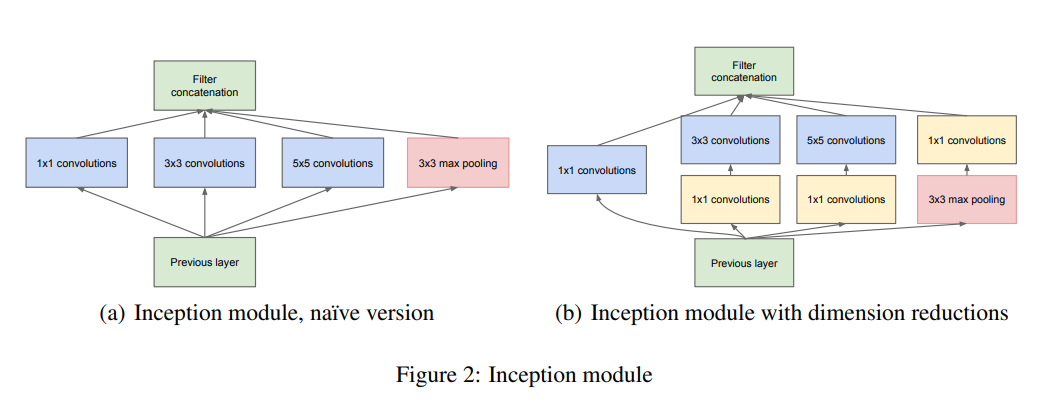

## BasicConv2d: Conv2d + BatchNorm + ReLU

In [3]:
# reference : https://pytorch.org/vision/main/_modules/torchvision/models/googlenet.html#googlenet
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

## Inception v1
아래 그림에서 우측(dimension reduction 버전으로 수행)
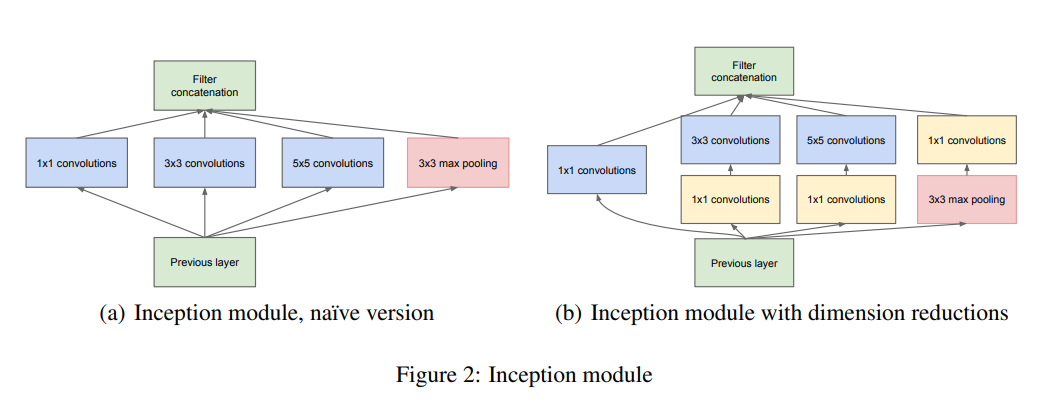

In [4]:
# Inception v1 module
class InceptionV1(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.branch1x1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1), # 1X1 conv
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1), # 1X1 conv
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1), 
            BasicConv2d(in_channels, pool_proj, kernel_size=1) # 1X1 conv
        )

    def forward(self, x):
        """
            output shape : (batch, ch1x1 + ch3x3 + ch5x5 + pool_proj, height, width)
        """
        return torch.cat([
            self.branch1x1(x),
            self.branch3x3(x),
            self.branch5x5(x),
            self.branch_pool(x)
        ], 1) # channel wise concat, image shape : (batch, channel, height, width)

## Auxiliary Classifier
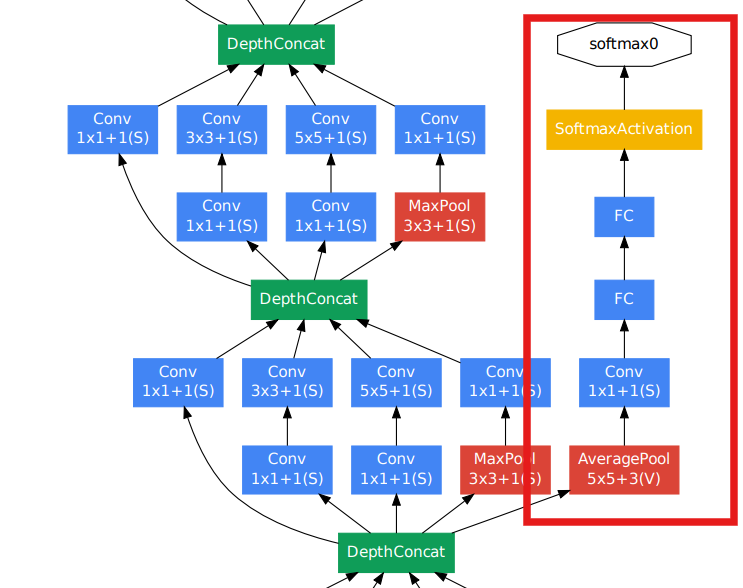

In [5]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # Approx equivalent to kernel=5, stride=3
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## GoogLeNet
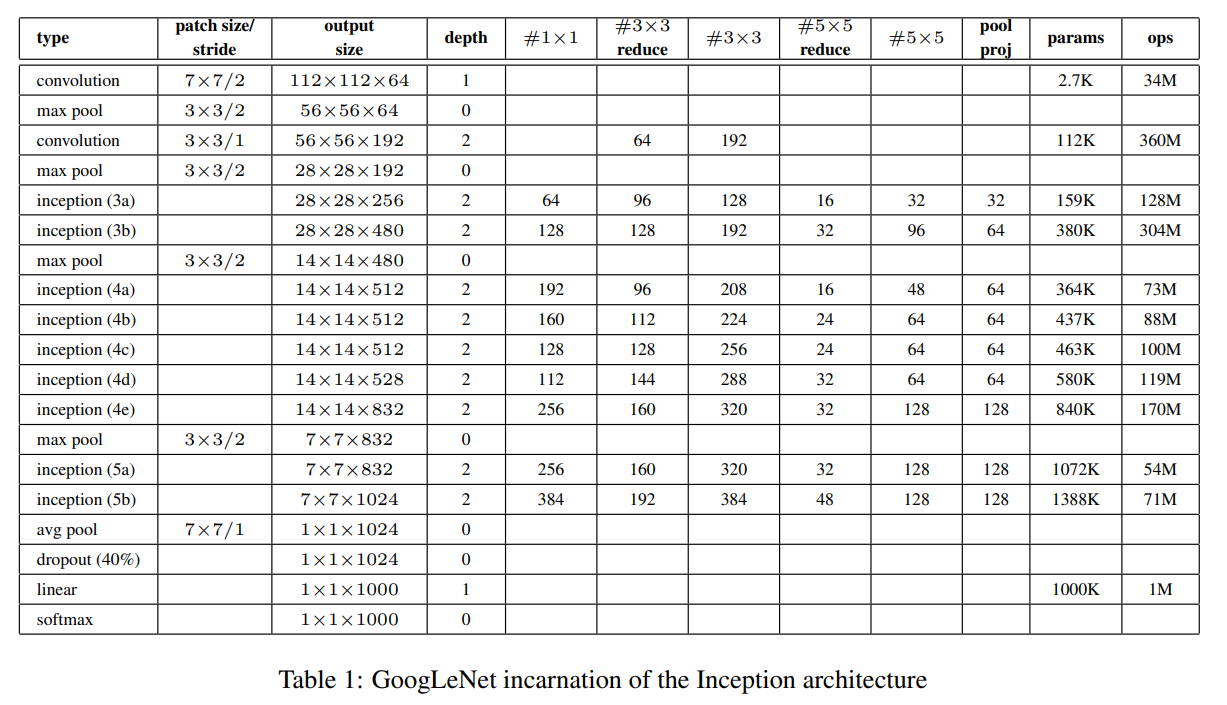

In [6]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits
        
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = InceptionV1(192, 64, 96, 128, 16, 32, 32)  # output : (batch, 64+128+32+32(256), 28, 28)
        self.inception3b = InceptionV1(256, 128, 128, 192, 32, 96, 64) # output : (batch, 128+192+96+64(480), 28, 28)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = InceptionV1(480, 192, 96, 208, 16, 48, 64) # output : (batch, 192+208+48+64(512), 14, 14)
        self.inception4b = InceptionV1(512, 160, 112, 224, 24, 64, 64) # output : (batch, 160+224+64+64(512), 14, 14)
        self.inception4c = InceptionV1(512, 128, 128, 256, 24, 64, 64) # output : (batch, 128+256+64+64(512), 14, 14)
        self.inception4d = InceptionV1(512, 112, 144, 288, 32, 64, 64) # output : (batch, 112+288+64+64(528), 14, 14)
        self.inception4e = InceptionV1(528, 256, 160, 320, 32, 128, 128) # output : (batch, 256+320+128+128(832), 14, 14)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # Auxiliary classifiers
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)  # after 4a
            self.aux2 = InceptionAux(528, num_classes)  # after 4d
        
        self.inception5a = InceptionV1(832, 256, 160, 320, 32, 128, 128) # output : (batch, 256+320+128+128(832), 7, 7)
        self.inception5b = InceptionV1(832, 384, 192, 384, 48, 128, 128) # output : (batch, 384+384+128+128(1024), 7, 7)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        aux1 = self.aux1(x) if self.aux_logits and self.training else None
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = self.aux2(x) if self.aux_logits and self.training else None
        
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training: # 학습 중 일때만 Auxiliary Classifier 적용, self.training은 nn.module가 관리하는 인스턴스 변수 -> eval mode에서 False로 처리됨
            return x, aux1, aux2
        else:
            return x

# GoogLeNet 구조 확인

In [7]:
import torchsummary
model = GoogLeNet(num_classes = 10).to(device) # 데이터 셋의 클래스 수 : 10개

torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# 손실 함수, 옵티마이저, lr scheduler 설정

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(weight_decay=WEIGHT_DECAY, params=model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, verbose=True, patience=10)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train

In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Auxiliary classifier 지원
        if isinstance(outputs, tuple): # train
            main_output, aux1_output, aux2_output = outputs
            loss1 = criterion(main_output, labels)
            loss2 = criterion(aux1_output, labels)
            loss3 = criterion(aux2_output, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
            outputs = main_output  # 예측은 main output 기준
        else: # test
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# test

In [10]:
# 테스트 루프
def test(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Only use main output for evaluation

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation

In [11]:
min_loss = np.inf
MODEL_NAME = "GoogLeNet_best"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Early stopping 설정
patience = 5  # val_loss 개선되지 않는 최대 epoch 수
early_stop_counter = 0  # 개선되지 않은 epoch 수

# Epoch 별 train & test
for epoch in tqdm(range(epochs)):
    # Model Training
    # train result
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)

    # validation result
    val_loss, val_acc = test(model, testloader, criterion, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')
        early_stop_counter = 0 # 개선되었으므로 early stopping counter 리셋
    else:
        early_stop_counter += 1 # 개선되지 않았으면 카운터 증가

    # learning rate update
    lr_scheduler.step(metrics=val_loss)
    
    # Epoch 별 결과
    print(f'epoch {epoch+1:02d}, train_loss: {train_loss:.5f}, train_acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    # 결과 저장
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    
    # Early stopping
    # if early_stop_counter >= patience:
    #     print(f'Early stopping at epoch {epoch}...')
    #     break

  2%|▏         | 1/50 [02:20<1:54:52, 140.65s/it]

[INFO] val_loss has been improved from inf to 1.30142. Saving Model!
epoch 01, train_loss: 2.18733, train_acc: 49.08000, val_loss: 1.30142, val_accuracy: 54.63000


  4%|▍         | 2/50 [04:39<1:51:42, 139.64s/it]

[INFO] val_loss has been improved from 1.30142 to 1.05685. Saving Model!
epoch 02, train_loss: 1.50254, train_acc: 66.83800, val_loss: 1.05685, val_accuracy: 63.86000


  6%|▌         | 3/50 [06:58<1:48:58, 139.13s/it]

[INFO] val_loss has been improved from 1.05685 to 0.88598. Saving Model!
epoch 03, train_loss: 1.18878, train_acc: 74.63000, val_loss: 0.88598, val_accuracy: 68.91000


  8%|▊         | 4/50 [09:16<1:46:35, 139.02s/it]

[INFO] val_loss has been improved from 0.88598 to 0.66130. Saving Model!
epoch 04, train_loss: 1.00551, train_acc: 78.85200, val_loss: 0.66130, val_accuracy: 76.87000


 10%|█         | 5/50 [11:37<1:44:36, 139.47s/it]

epoch 05, train_loss: 0.88055, train_acc: 81.72400, val_loss: 0.84104, val_accuracy: 71.79000


 12%|█▏        | 6/50 [13:56<1:42:08, 139.29s/it]

[INFO] val_loss has been improved from 0.66130 to 0.57023. Saving Model!
epoch 06, train_loss: 0.78902, train_acc: 84.00600, val_loss: 0.57023, val_accuracy: 80.40000


 14%|█▍        | 7/50 [16:15<1:39:44, 139.18s/it]

[INFO] val_loss has been improved from 0.57023 to 0.49947. Saving Model!
epoch 07, train_loss: 0.72335, train_acc: 85.46800, val_loss: 0.49947, val_accuracy: 83.17000


 16%|█▌        | 8/50 [18:35<1:37:43, 139.60s/it]

[INFO] val_loss has been improved from 0.49947 to 0.48798. Saving Model!
epoch 08, train_loss: 0.66290, train_acc: 86.66400, val_loss: 0.48798, val_accuracy: 83.41000


 18%|█▊        | 9/50 [20:54<1:35:16, 139.42s/it]

epoch 09, train_loss: 0.61527, train_acc: 87.87400, val_loss: 0.51618, val_accuracy: 82.98000


 20%|██        | 10/50 [23:13<1:32:56, 139.40s/it]

epoch 10, train_loss: 0.56272, train_acc: 88.92400, val_loss: 0.55530, val_accuracy: 81.80000


 22%|██▏       | 11/50 [25:33<1:30:36, 139.40s/it]

epoch 11, train_loss: 0.52800, train_acc: 89.74600, val_loss: 0.53898, val_accuracy: 82.14000


 24%|██▍       | 12/50 [27:52<1:28:12, 139.27s/it]

epoch 12, train_loss: 0.49468, train_acc: 90.51000, val_loss: 0.60585, val_accuracy: 80.77000


 26%|██▌       | 13/50 [30:11<1:25:47, 139.11s/it]

epoch 13, train_loss: 0.45750, train_acc: 91.24200, val_loss: 0.49434, val_accuracy: 83.85000


 28%|██▊       | 14/50 [32:31<1:23:45, 139.61s/it]

epoch 14, train_loss: 0.41906, train_acc: 92.03800, val_loss: 0.50274, val_accuracy: 84.39000


 30%|███       | 15/50 [34:50<1:21:20, 139.44s/it]

epoch 15, train_loss: 0.39993, train_acc: 92.34800, val_loss: 0.51726, val_accuracy: 83.53000


 32%|███▏      | 16/50 [37:10<1:18:57, 139.34s/it]

epoch 16, train_loss: 0.37369, train_acc: 93.01800, val_loss: 0.51142, val_accuracy: 83.62000


 34%|███▍      | 17/50 [39:29<1:16:34, 139.23s/it]

epoch 17, train_loss: 0.34703, train_acc: 93.53800, val_loss: 0.52151, val_accuracy: 83.87000


 36%|███▌      | 18/50 [41:48<1:14:13, 139.17s/it]

epoch 18, train_loss: 0.33009, train_acc: 93.97600, val_loss: 0.49218, val_accuracy: 84.90000


 38%|███▊      | 19/50 [44:08<1:12:08, 139.62s/it]

epoch 19, train_loss: 0.31114, train_acc: 94.41000, val_loss: 0.55137, val_accuracy: 83.30000


 40%|████      | 20/50 [46:27<1:09:45, 139.52s/it]

[INFO] val_loss has been improved from 0.48798 to 0.35736. Saving Model!
epoch 20, train_loss: 0.14143, train_acc: 98.10400, val_loss: 0.35736, val_accuracy: 89.32000


 42%|████▏     | 21/50 [48:46<1:07:20, 139.32s/it]

epoch 21, train_loss: 0.08470, train_acc: 99.23600, val_loss: 0.37256, val_accuracy: 89.30000


 44%|████▍     | 22/50 [51:07<1:05:09, 139.62s/it]

epoch 22, train_loss: 0.06687, train_acc: 99.54400, val_loss: 0.38097, val_accuracy: 89.20000


 46%|████▌     | 23/50 [53:26<1:02:43, 139.40s/it]

epoch 23, train_loss: 0.05388, train_acc: 99.71400, val_loss: 0.38868, val_accuracy: 89.23000


 48%|████▊     | 24/50 [55:45<1:00:25, 139.44s/it]

epoch 24, train_loss: 0.04537, train_acc: 99.82000, val_loss: 0.39542, val_accuracy: 89.34000


 50%|█████     | 25/50 [58:04<58:05, 139.42s/it]  

epoch 25, train_loss: 0.03939, train_acc: 99.90800, val_loss: 0.39727, val_accuracy: 89.41000


 52%|█████▏    | 26/50 [1:00:24<55:44, 139.34s/it]

epoch 26, train_loss: 0.03644, train_acc: 99.92000, val_loss: 0.41293, val_accuracy: 89.36000


 54%|█████▍    | 27/50 [1:02:43<53:21, 139.20s/it]

epoch 27, train_loss: 0.03341, train_acc: 99.93800, val_loss: 0.41737, val_accuracy: 89.00000


 56%|█████▌    | 28/50 [1:05:02<51:02, 139.22s/it]

epoch 28, train_loss: 0.03024, train_acc: 99.93200, val_loss: 0.42397, val_accuracy: 88.98000


 58%|█████▊    | 29/50 [1:07:21<48:41, 139.10s/it]

epoch 29, train_loss: 0.02862, train_acc: 99.94800, val_loss: 0.42120, val_accuracy: 89.15000


 60%|██████    | 30/50 [1:09:40<46:23, 139.15s/it]

epoch 30, train_loss: 0.02654, train_acc: 99.94000, val_loss: 0.44710, val_accuracy: 88.69000


 62%|██████▏   | 31/50 [1:11:59<44:02, 139.07s/it]

epoch 31, train_loss: 0.02528, train_acc: 99.94600, val_loss: 0.45053, val_accuracy: 88.68000


 64%|██████▍   | 32/50 [1:14:18<41:43, 139.08s/it]

epoch 32, train_loss: 0.01985, train_acc: 99.97200, val_loss: 0.42785, val_accuracy: 89.17000


 66%|██████▌   | 33/50 [1:16:37<39:24, 139.06s/it]

epoch 33, train_loss: 0.01818, train_acc: 99.98400, val_loss: 0.42841, val_accuracy: 89.04000


 68%|██████▊   | 34/50 [1:18:56<37:05, 139.07s/it]

epoch 34, train_loss: 0.01716, train_acc: 99.99000, val_loss: 0.42097, val_accuracy: 89.22000


 70%|███████   | 35/50 [1:21:15<34:46, 139.13s/it]

epoch 35, train_loss: 0.01691, train_acc: 99.99200, val_loss: 0.42612, val_accuracy: 89.14000


 72%|███████▏  | 36/50 [1:23:34<32:26, 139.04s/it]

epoch 36, train_loss: 0.01698, train_acc: 99.98000, val_loss: 0.42235, val_accuracy: 89.16000


 74%|███████▍  | 37/50 [1:25:53<30:07, 139.02s/it]

epoch 37, train_loss: 0.01655, train_acc: 99.99400, val_loss: 0.41996, val_accuracy: 89.19000


 76%|███████▌  | 38/50 [1:28:12<27:47, 139.00s/it]

epoch 38, train_loss: 0.01599, train_acc: 99.99200, val_loss: 0.42217, val_accuracy: 89.11000


 78%|███████▊  | 39/50 [1:30:31<25:28, 138.97s/it]

epoch 39, train_loss: 0.01644, train_acc: 99.99600, val_loss: 0.42491, val_accuracy: 89.14000


 80%|████████  | 40/50 [1:32:50<23:09, 138.99s/it]

epoch 40, train_loss: 0.01625, train_acc: 99.98600, val_loss: 0.42720, val_accuracy: 89.20000


 82%|████████▏ | 41/50 [1:35:09<20:51, 139.01s/it]

epoch 41, train_loss: 0.01587, train_acc: 99.99400, val_loss: 0.42230, val_accuracy: 89.15000


 84%|████████▍ | 42/50 [1:37:28<18:32, 139.04s/it]

epoch 42, train_loss: 0.01597, train_acc: 99.99800, val_loss: 0.42132, val_accuracy: 89.10000


 86%|████████▌ | 43/50 [1:39:47<16:13, 139.02s/it]

epoch 43, train_loss: 0.01491, train_acc: 99.99600, val_loss: 0.42369, val_accuracy: 89.12000


 88%|████████▊ | 44/50 [1:42:06<13:54, 139.08s/it]

epoch 44, train_loss: 0.01482, train_acc: 99.99200, val_loss: 0.42330, val_accuracy: 89.02000


 90%|█████████ | 45/50 [1:44:25<11:35, 139.11s/it]

epoch 45, train_loss: 0.01477, train_acc: 99.99600, val_loss: 0.42323, val_accuracy: 89.09000


 92%|█████████▏| 46/50 [1:46:45<09:16, 139.14s/it]

epoch 46, train_loss: 0.01478, train_acc: 99.99800, val_loss: 0.42566, val_accuracy: 89.16000


 94%|█████████▍| 47/50 [1:49:04<06:57, 139.15s/it]

epoch 47, train_loss: 0.01490, train_acc: 99.99200, val_loss: 0.42537, val_accuracy: 89.19000


 96%|█████████▌| 48/50 [1:51:23<04:38, 139.16s/it]

epoch 48, train_loss: 0.01497, train_acc: 99.99800, val_loss: 0.42295, val_accuracy: 89.17000


 98%|█████████▊| 49/50 [1:53:42<02:19, 139.17s/it]

epoch 49, train_loss: 0.01457, train_acc: 99.99600, val_loss: 0.42276, val_accuracy: 89.20000


100%|██████████| 50/50 [1:56:01<00:00, 139.24s/it]

epoch 50, train_loss: 0.01492, train_acc: 99.99800, val_loss: 0.42459, val_accuracy: 89.07000


# train/valid acc,loss 시각화

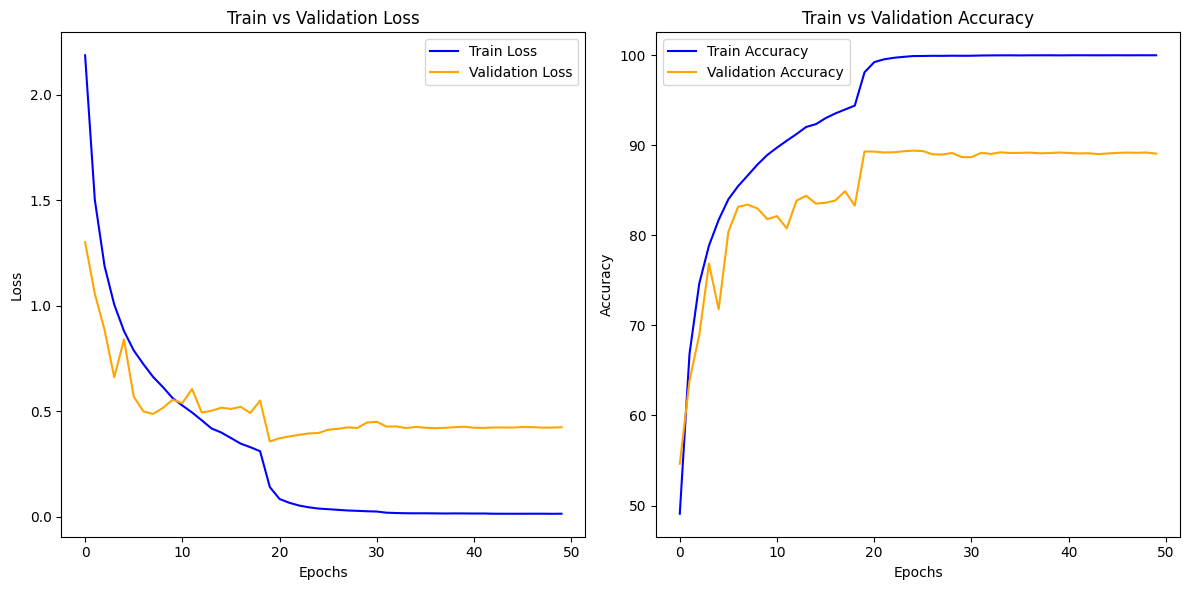

In [12]:
import matplotlib.pyplot as plt
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)

    # Loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)